<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: [*Xiaoye Zhang*]
### ***username***: [*acse-xz4019*]
### ***CID***: [*01702739*]


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Hyperparameter tunning notebook

Explain the steps and tests you do.

Organise it well to show how the data you present here has helped you design your final network hyperparameters (that you will use for the final training in the `yourusername_DLcw1_clean.ipynb` notebook).

### Baseline Model: fully connected layer from lecture notes

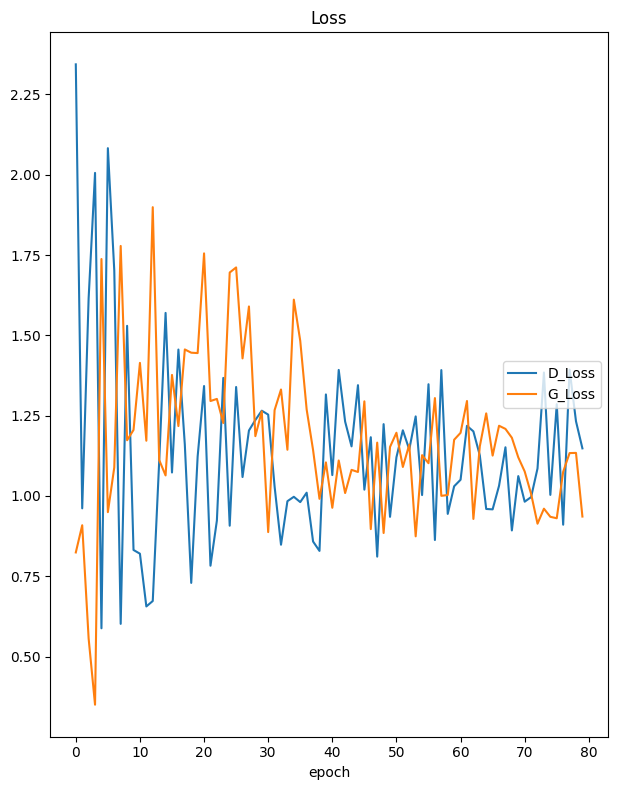

Loss
	D_Loss           	 (min:    0.588, max:    2.344, cur:    1.148)
	G_Loss           	 (min:    0.350, max:    1.899, cur:    0.936)


## My first GAN
I get a generator with one nn.Linear layer, three nn.ConvTranspose2d layers, and one nn.Conv2d layer.
And a discriminator with four nn.Conv2d layers.
I modify it from (Radford, A., Metz, L. and Chintala, S. (2016)).
Here is the result after 80 epochs.
However, I find that the loss of generator and the loss of discriminator will never converge because the convolutional neural network is to big. So I interrupt the process.

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=(1, 32, 32)):
        
        super().__init__()
        # self.fc1 = nn.Linear(g_input_dim, 256)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        # self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        self.layer1 = nn.Sequential(nn.Linear(g_input_dim, 512*4*4),
                                    nn.BatchNorm1d(512*4*4),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512, 256, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(128, 64, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=64, 
                                    out_channels=1, 
                                    kernel_size=1, 
                                    stride=1, 
                                    padding=0),
                                    nn.BatchNorm2d(1),
                                    nn.Tanh())

    # forward method
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x.view(-1, 512, 4, 4))
        x = self.layer3(x)
        x = self.layer4(x)
        return self.layer5(x).squeeze(1)

class DCDiscriminator(nn.Module):
    def __init__(self,):
        super().__init__()
        # self.fc1 = nn.Linear(d_input_dim, 1024)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        # self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64,
                                    out_channels=128,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=128,
                                    out_channels=512,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=512,
                                    out_channels=1,
                                    kernel_size=4,
                                    stride=2,
                                    padding=0),
                                    nn.Sigmoid(),
                                    nn.Flatten())
    # forward method
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# build model
DCG = DCGenerator().to(device)
DCD = DCDiscriminator().to(device)
# define loss
criterion = nn.BCELoss()
z_dim = 100
bs = 32  ## batch_size


# optimiser
lr = 0.0001
DCG_optimizer = torch.optim.Adam(DCG.parameters(), lr = lr)
DCD_optimizer = torch.optim.Adam(DCD.parameters(), lr = lr)
def DCD_train(x):
    # Function for discriminator training
    DCD.train()
    DCD_optimizer.zero_grad()

    # Reshape the input and prepare real labels
    x_real, y_real = x.view(bs, 1, 32, 32).to(device), torch.ones(bs, 1).to(device)  # Ensure x is [bs, 1, 32, 32]
    
    # Train discriminator on real data
    DCD_output = DCD(x_real)
    DCD_real_loss = criterion(DCD_output, y_real)

    # Train discriminator on fake data
    z = torch.randn(bs, z_dim).to(device)  # Generate random noise
    x_fake, y_fake = DCG(z), torch.zeros(bs, 1).to(device)

    DCD_output = DCD(x_fake)
    DCD_fake_loss = criterion(DCD_output, y_fake)

    # Combine the losses and update
    DCD_loss = DCD_real_loss + DCD_fake_loss
    DCD_loss.backward()
    DCD_optimizer.step()

    return DCD_loss.item()


def DCG_train(x):
    #-------------- Function of the generator training -------------------#
    DCG.train()
    DCG_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    DCG_output = DCG(z)

    # obtain scores from D for the generated data
    DCD_output = DCD(DCG_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    DCG_loss = criterion(DCD_output, y)

    # model update
    DCG_loss.backward()
    DCG_optimizer.step()

    return DCG_loss.data.item()



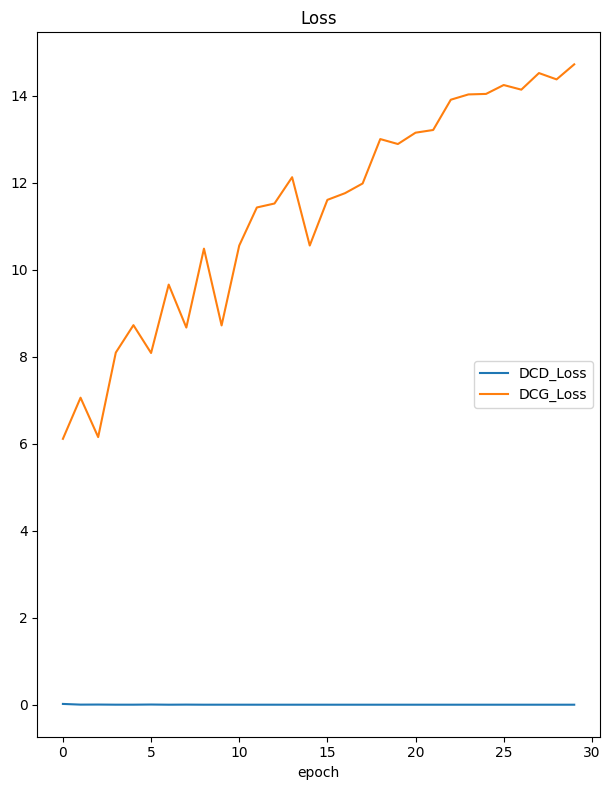

Loss
	DCD_Loss         	 (min:    0.000, max:    0.018, cur:    0.000)
	DCG_Loss         	 (min:    6.113, max:   14.724, cur:   14.724)


KeyboardInterrupt: 

I know it won't converge, so i pause it.

## Modification: Decrease the size of Conv layers
The losses start to converge, but looks like the performance is still poor. This may because I squezze the size too much.

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=(1, 32, 32)):
        
        super().__init__()
        # self.fc1 = nn.Linear(g_input_dim, 256)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        # self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        self.layer1 = nn.Sequential(nn.Linear(g_input_dim, 32*4*4),
                                    nn.BatchNorm1d(32*4*4),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(32, 16, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(16, 8, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(8, 4, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(4),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=4, 
                                    out_channels=1, 
                                    kernel_size=1, 
                                    stride=1, 
                                    padding=0),
                                    nn.BatchNorm2d(1),
                                    nn.Tanh())

    # forward method
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x.view(-1, 32, 4, 4))
        x = self.layer3(x)
        x = self.layer4(x)
        return self.layer5(x).squeeze(1)

class DCDiscriminator(nn.Module):
    def __init__(self,):
        super().__init__()
        # self.fc1 = nn.Linear(d_input_dim, 1024)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        # self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                    out_channels=8, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(8),
                                    nn.LeakyReLU(0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=8,
                                    out_channels=16,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(16),
                                    nn.LeakyReLU(0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=16,
                                    out_channels=32,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.LeakyReLU(0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=32,
                                    out_channels=1,
                                    kernel_size=4,
                                    stride=2,
                                    padding=0),
                                    nn.Sigmoid(),
                                    nn.Flatten())
    # forward method
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# build model
DCG = DCGenerator().to(device)
DCD = DCDiscriminator().to(device)

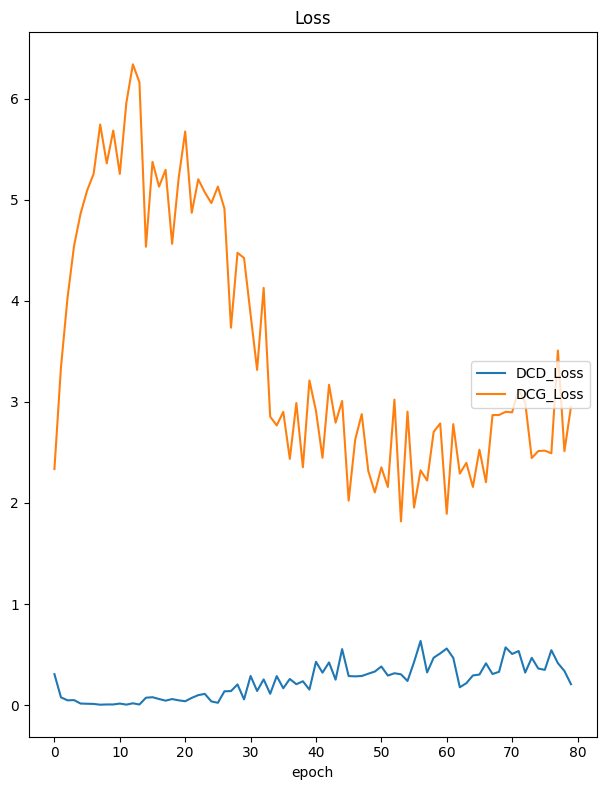

Loss
	DCD_Loss         	 (min:    0.004, max:    0.635, cur:    0.207)
	DCG_Loss         	 (min:    1.817, max:    6.338, cur:    2.951)


## Modification: Resize the Conv layers back to large size but remove all FCN layers
This time the losses converge quickly.


In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=(1, 32, 32)):
        
        super().__init__()
        # self.fc1 = nn.Linear(g_input_dim, 256)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        # self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(g_input_dim, 512, 
                                    kernel_size=4, stride=1, padding=0),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512, 256, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(64, 1, 
                                    kernel_size=3, 
                                    stride=1, 
                                    padding=1),
                                    nn.Tanh())

    # forward method
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)  # Reshape the input tensor
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.layer5(x)

class DCDiscriminator(nn.Module):
    def __init__(self,):
        super().__init__()
        # self.fc1 = nn.Linear(d_input_dim, 1024)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        # self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                    out_channels=128, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                    out_channels=256,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                    out_channels=512,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=512,
                                    out_channels=1,
                                    kernel_size=4,
                                    stride=1,
                                    padding=0),
                                    nn.Sigmoid(),
                                    nn.Flatten())
    # forward method
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x.view(-1, 1)

# build model
DCG = DCGenerator().to(device)
DCD = DCDiscriminator().to(device)

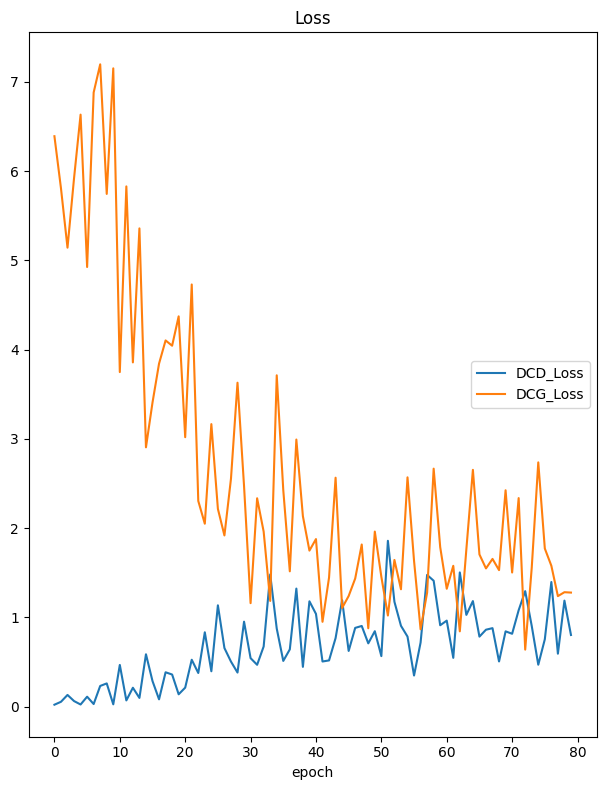

Loss
	DCD_Loss         	 (min:    0.020, max:    1.857, cur:    0.801)
	DCG_Loss         	 (min:    0.637, max:    7.196, cur:    1.277)


### These are the generator after 20 epochs, looks like it can generate images looks like hands.

Text(0.5, 1.0, 'Epoch = 020')

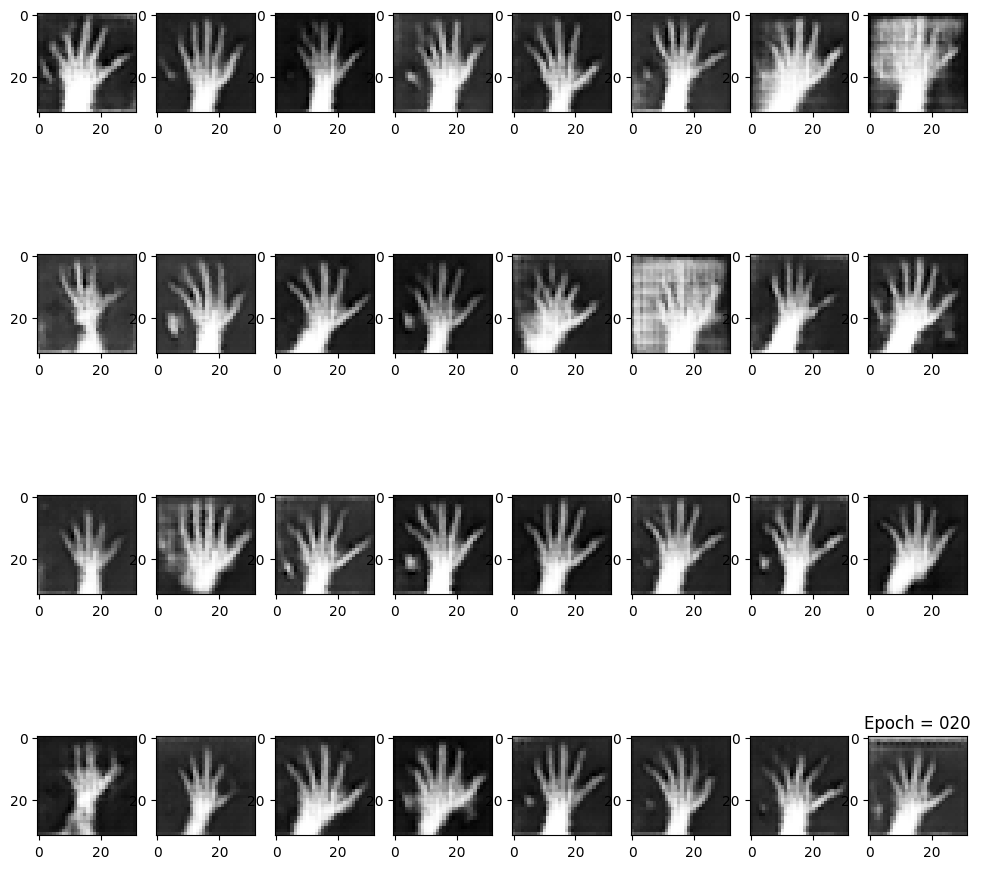

## Modification: alter the optimizer, use RMSprop instead of Adam
The losses converge first then diverge, the performence of RMSprop is poorer than using Adam

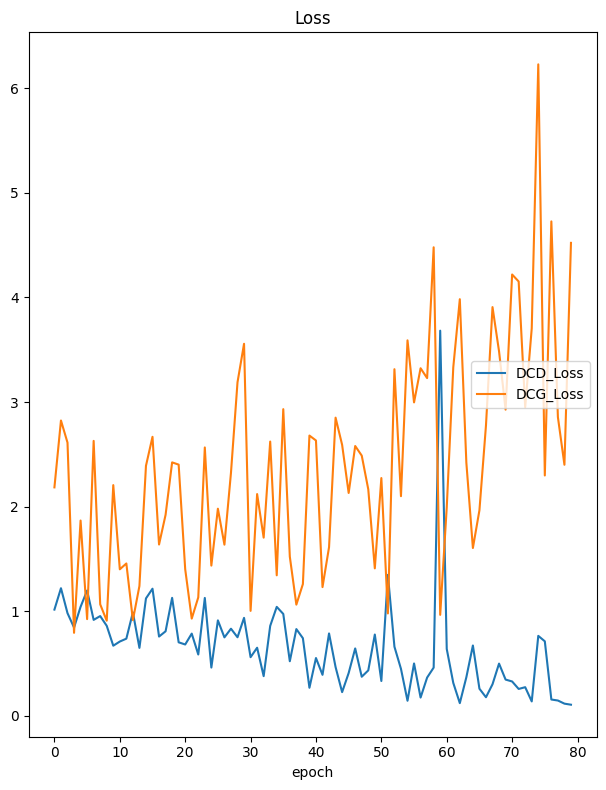

Loss
	DCD_Loss         	 (min:    0.108, max:    3.682, cur:    0.108)
	DCG_Loss         	 (min:    0.795, max:    6.228, cur:    4.522)


## Modification: alter the optimizer, use SGD instead of Adam
The losses never converge, the performence of SGD is poorer than using Adam

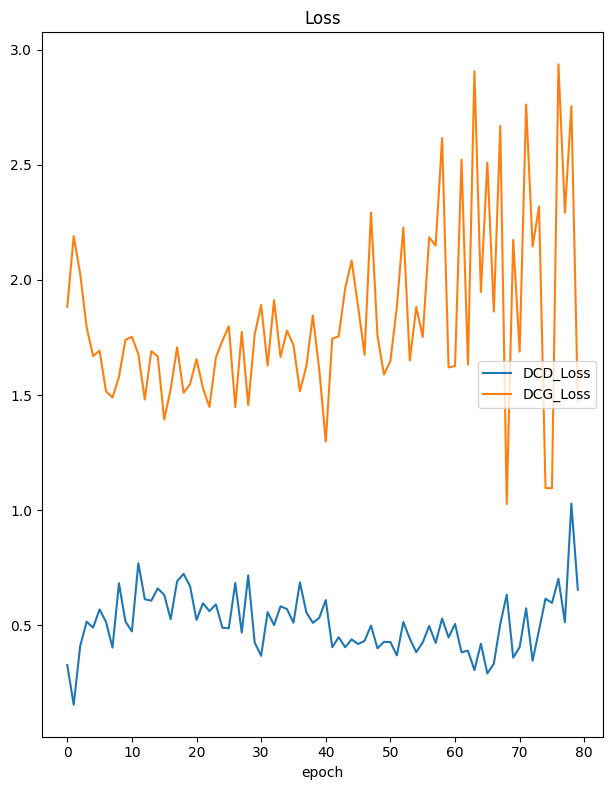

Loss
	DCD_Loss         	 (min:    0.155, max:    1.028, cur:    0.654)
	DCG_Loss         	 (min:    1.027, max:    2.936, cur:    1.471)


## Modification: alter the optimizer, use AdamW instead of Adam
The losses converge fast, and looks it can keep converging, using AdamW could be a good choice

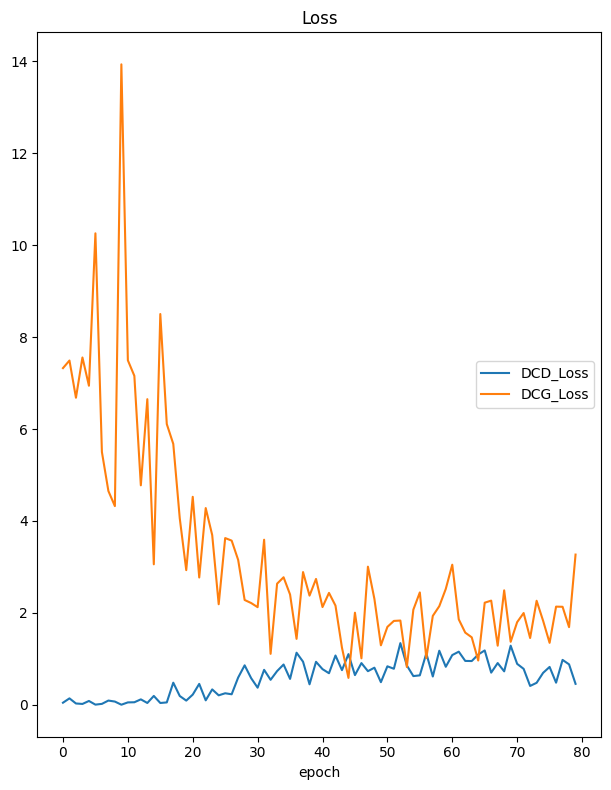

100%|██████████| 80/80 [08:36<00:00,  6.45s/it]

Loss
	DCD_Loss         	 (min:    0.002, max:    1.342, cur:    0.456)
	DCG_Loss         	 (min:    0.586, max:   13.935, cur:    3.269)


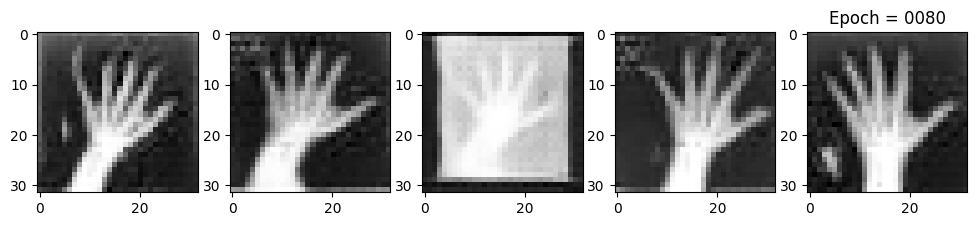

## Finetuning: alter the learning rater, from 1e-3 to 1e-2
As the learning rate increases, the performance decrease, so it should use a small learning rate.

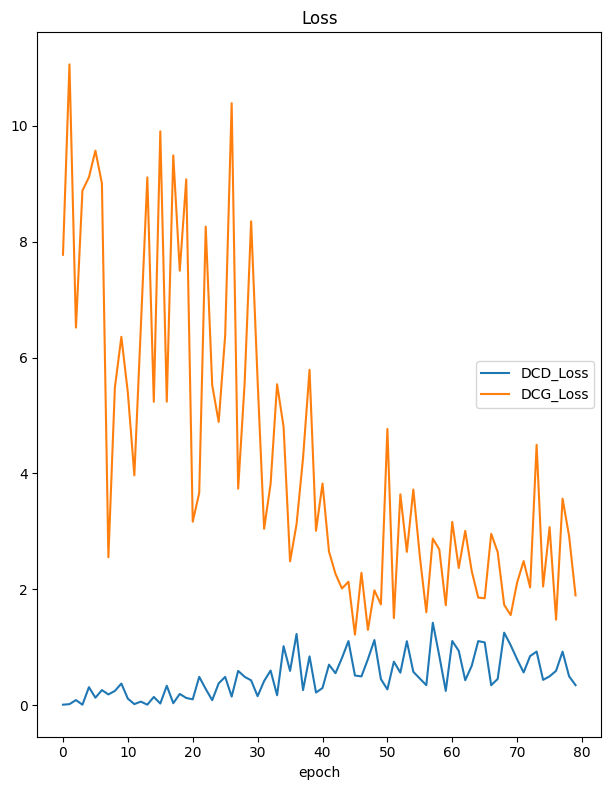

100%|██████████| 80/80 [08:33<00:00,  6.42s/it]

Loss
	DCD_Loss         	 (min:    0.008, max:    1.423, cur:    0.345)
	DCG_Loss         	 (min:    1.218, max:   11.062, cur:    1.895)


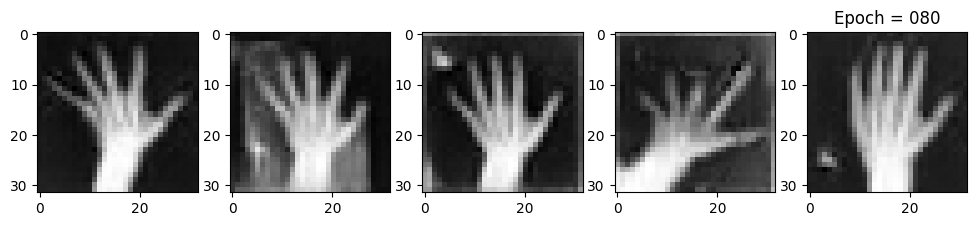

## Modification: add dropout layers to prevent weights become too big
Looks like the performance does not change a lot, maybe the location of dropout is not perfect, or coeffient of dropoout is too small?

In [ ]:
class DCGenerator(nn.Module):
    """
    Generator Class

    Parameters
    ----------
    g_input_dim : int
        Input dimension for the generator, default = 100
    g_output_dim : tuple
        Output dimension for the generator, default = (1, 32, 32)

    Returns
    -------
    None

    References
    ----------
    https://arxiv.org/pdf/1511.06434.pdf
    """

    def __init__(self, g_input_dim=100, g_output_dim=(1, 32, 32)):
        super().__init__()
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(g_input_dim, 512, 
                                    kernel_size=4, stride=1, padding=0),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512, 256, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(64, 1, 
                                    kernel_size=3, 
                                    stride=1, 
                                    padding=1),
                                    nn.Tanh())
        self.dropout = nn.Dropout(p=0.5)

    # forward method
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)  # Reshape the input tensor
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        return self.layer5(x)

class DCDiscriminator(nn.Module):
    """
    Discriminator Class

    Parameters
    ----------
    d_input_dim : tuple
        Input dimension for the discriminator, default = (1, 32, 32)

    Returns
    -------
    None
    """
    def __init__(self,):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                    out_channels=128, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                    out_channels=256,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                    out_channels=512,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=512,
                                    out_channels=1,
                                    kernel_size=4,
                                    stride=1,
                                    padding=0),
                                    nn.Sigmoid(),
                                    nn.Flatten())
        self.dropout = nn.Dropout(p=0.5)
    # forward method
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        return x.view(-1, 1)

# build model
DCG = DCGenerator().to(device)
DCD = DCDiscriminator().to(device)

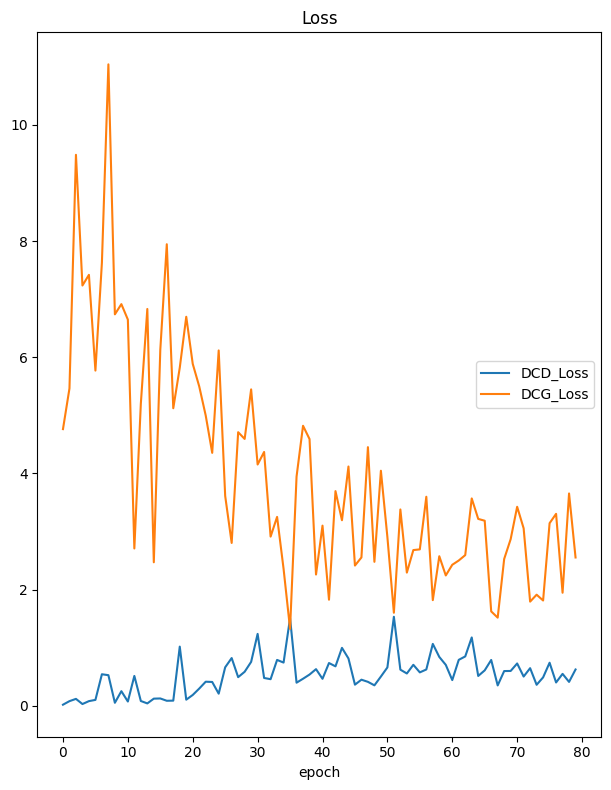

100%|██████████| 80/80 [08:37<00:00,  6.47s/it]

Loss
	DCD_Loss         	 (min:    0.017, max:    1.531, cur:    0.623)
	DCG_Loss         	 (min:    1.323, max:   11.042, cur:    2.552)


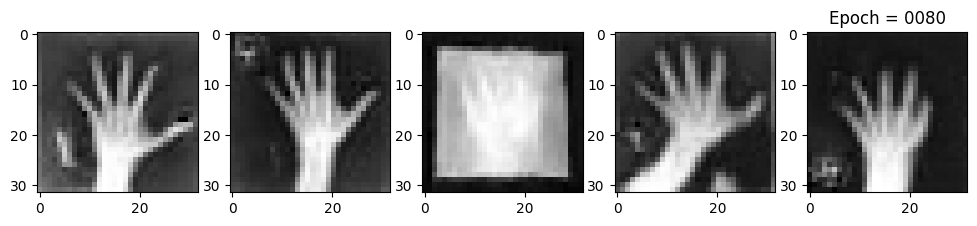

## Finetuning: add as many dropout layers as possible
Dropout layers do help, but too many dropout may not help?

In [ ]:
class DCGenerator(nn.Module):
    """
    Generator Class

    Parameters
    ----------
    g_input_dim : int
        Input dimension for the generator, default = 100
    g_output_dim : tuple
        Output dimension for the generator, default = (1, 32, 32)

    Returns
    -------
    None

    References
    ----------
    https://arxiv.org/pdf/1511.06434.pdf
    """

    def __init__(self, g_input_dim=100, g_output_dim=(1, 32, 32)):
        super().__init__()
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(g_input_dim, 512, 
                                    kernel_size=4, stride=1, padding=0),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512, 256, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(64, 1, 
                                    kernel_size=3, 
                                    stride=1, 
                                    padding=1),
                                    nn.Tanh())
        self.dropout = nn.Dropout(p=0.3)

    # forward method
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)  # Reshape the input tensor
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.dropout(x)
        return self.layer5(x)

class DCDiscriminator(nn.Module):
    """
    Discriminator Class

    Parameters
    ----------
    d_input_dim : tuple
        Input dimension for the discriminator, default = (1, 32, 32)

    Returns
    -------
    None
    """
    def __init__(self,):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                    out_channels=128, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                    out_channels=256,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                    out_channels=512,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=512,
                                    out_channels=1,
                                    kernel_size=4,
                                    stride=1,
                                    padding=0),
                                    nn.Sigmoid(),
                                    nn.Flatten())
        self.dropout = nn.Dropout(p=0.3)
    # forward method
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        return x.view(-1, 1)

# build model
DCG = DCGenerator().to(device)
DCD = DCDiscriminator().to(device)

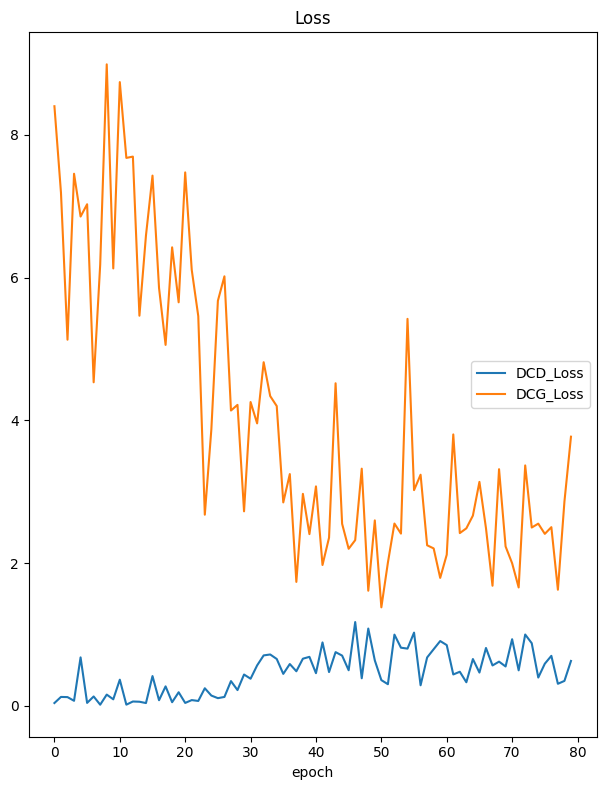

100%|██████████| 80/80 [08:51<00:00,  6.64s/it]

Loss
	DCD_Loss         	 (min:    0.016, max:    1.174, cur:    0.629)
	DCG_Loss         	 (min:    1.380, max:    8.988, cur:    3.771)


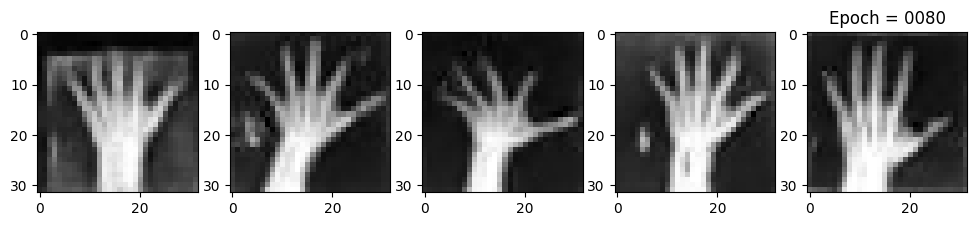

### Continue run till 200 epochs, it can be concluded that it should not need such many dropout layers. 

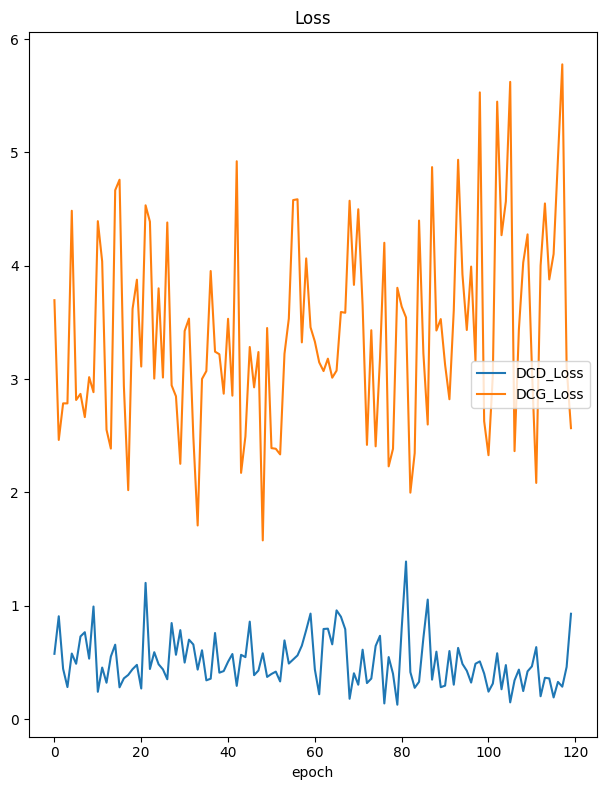

100%|██████████| 120/120 [04:05<00:00,  2.04s/it]

Loss
	DCD_Loss         	 (min:    0.127, max:    1.391, cur:    0.930)
	DCG_Loss         	 (min:    1.577, max:    5.778, cur:    2.567)


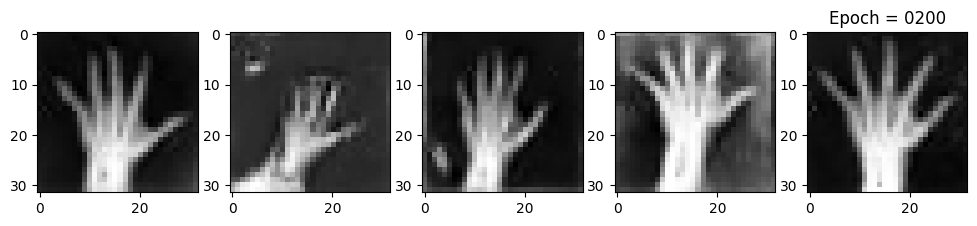

## Finetuning: reduce one dropout layer and choose a smaller learning rate
Looks it performs better

In [ ]:
class DCGenerator(nn.Module):
    """
    Generator Class

    Parameters
    ----------
    g_input_dim : int
        Input dimension for the generator, default = 100
    g_output_dim : tuple
        Output dimension for the generator, default = (1, 32, 32)

    Returns
    -------
    None

    References
    ----------
    https://arxiv.org/pdf/1511.06434.pdf
    """

    def __init__(self, g_input_dim=100, g_output_dim=(1, 32, 32)):
        super().__init__()
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(g_input_dim, 512, 
                                    kernel_size=4, stride=1, padding=0),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512, 256, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(64, 1, 
                                    kernel_size=3, 
                                    stride=1, 
                                    padding=1),
                                    nn.Tanh())
        self.dropout = nn.Dropout(p=0.3)

    # forward method
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)  # Reshape the input tensor
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.layer5(x)

class DCDiscriminator(nn.Module):
    """
    Discriminator Class

    Parameters
    ----------
    d_input_dim : tuple
        Input dimension for the discriminator, default = (1, 32, 32)

    Returns
    -------
    None
    """
    def __init__(self,):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                    out_channels=128, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                    out_channels=256,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                    out_channels=512,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=512,
                                    out_channels=1,
                                    kernel_size=4,
                                    stride=1,
                                    padding=0),
                                    nn.Sigmoid(),
                                    nn.Flatten())
        self.dropout = nn.Dropout(p=0.3)
    # forward method
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        return x.view(-1, 1)

# build model
DCG = DCGenerator().to(device)
DCD = DCDiscriminator().to(device)

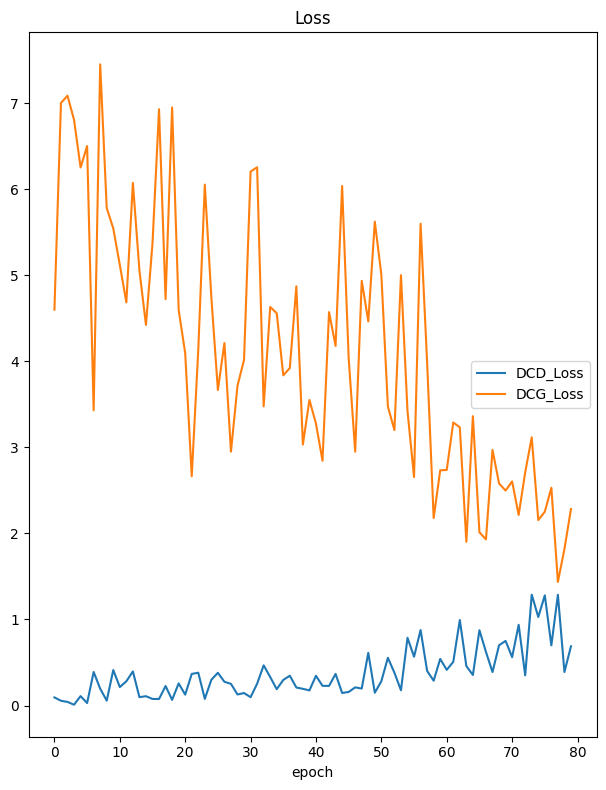

100%|██████████| 80/80 [02:41<00:00,  2.02s/it]

Loss
	DCD_Loss         	 (min:    0.009, max:    1.288, cur:    0.688)
	DCG_Loss         	 (min:    1.436, max:    7.449, cur:    2.283)


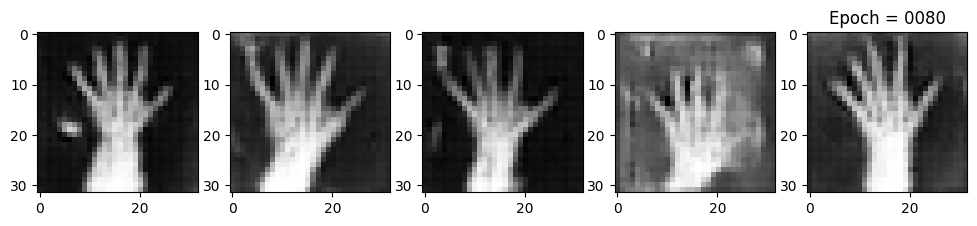

### Performance untill 200 epochs

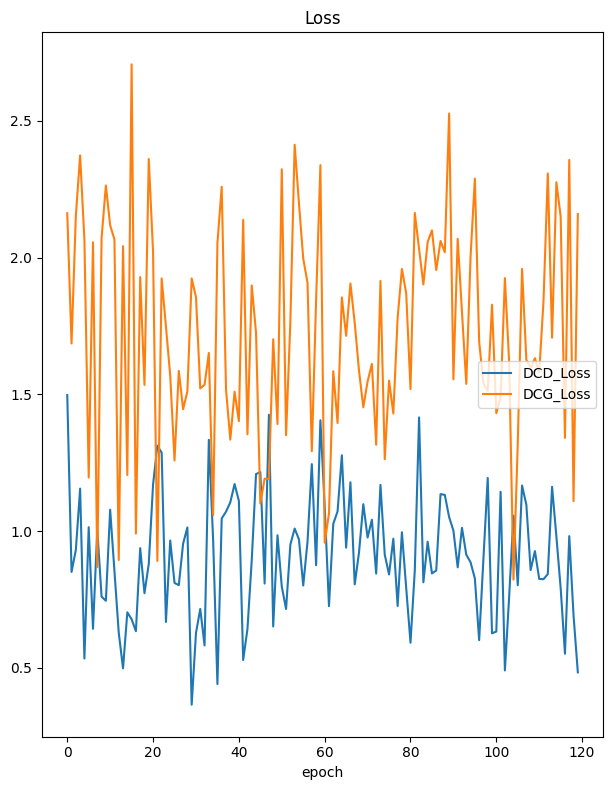

100%|██████████| 120/120 [04:01<00:00,  2.01s/it]

Loss
	DCD_Loss         	 (min:    0.365, max:    1.497, cur:    0.483)
	DCG_Loss         	 (min:    0.822, max:    2.707, cur:    2.159)


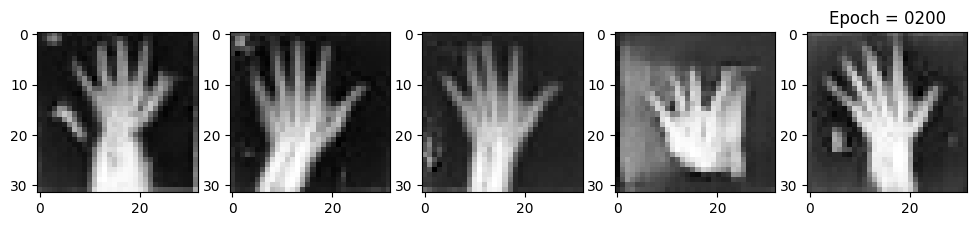

## Modification: reduce a dropout layer and set the learning rate of generator be half of that of discriminator
Performance looks good, but losses slightly diverge after 200 epochs. 

In [ ]:
class DCGenerator(nn.Module):
    """
    Generator Class

    Parameters
    ----------
    g_input_dim : int
        Input dimension for the generator, default = 100
    g_output_dim : tuple
        Output dimension for the generator, default = (1, 32, 32)

    Returns
    -------
    None

    References
    ----------
    https://arxiv.org/pdf/1511.06434.pdf
    """

    def __init__(self, g_input_dim=100, g_output_dim=(1, 32, 32)):
        super().__init__()
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(g_input_dim, 512, 
                                    kernel_size=4, stride=1, padding=0),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512, 256, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(64, 1, 
                                    kernel_size=3, 
                                    stride=1, 
                                    padding=1),
                                    nn.Tanh())
        self.dropout = nn.Dropout(p=0.2)

    # forward method
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)  # Reshape the input tensor
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.layer5(x)

class DCDiscriminator(nn.Module):
    """
    Discriminator Class

    Parameters
    ----------
    d_input_dim : tuple
        Input dimension for the discriminator, default = (1, 32, 32)

    Returns
    -------
    None
    """
    def __init__(self,):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                    out_channels=128, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                    out_channels=256,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                    out_channels=512,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=512,
                                    out_channels=1,
                                    kernel_size=4,
                                    stride=1,
                                    padding=0),
                                    nn.Sigmoid(),
                                    nn.Flatten())
        self.dropout = nn.Dropout(p=0.3)
    # forward method
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        return x.view(-1, 1)

# build model
DCG = DCGenerator().to(device)
DCD = DCDiscriminator().to(device)

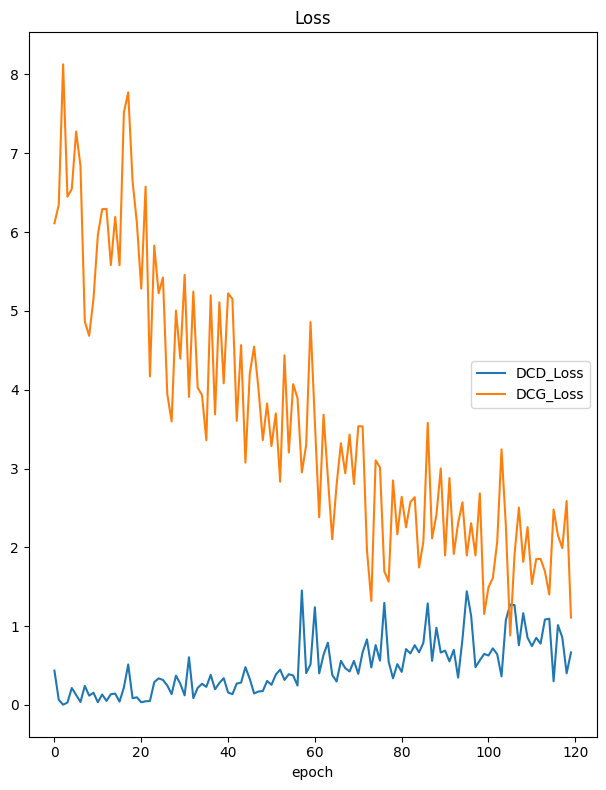

100%|██████████| 120/120 [04:03<00:00,  2.03s/it]

Loss
	DCD_Loss         	 (min:    0.003, max:    1.453, cur:    0.667)
	DCG_Loss         	 (min:    0.883, max:    8.128, cur:    1.109)


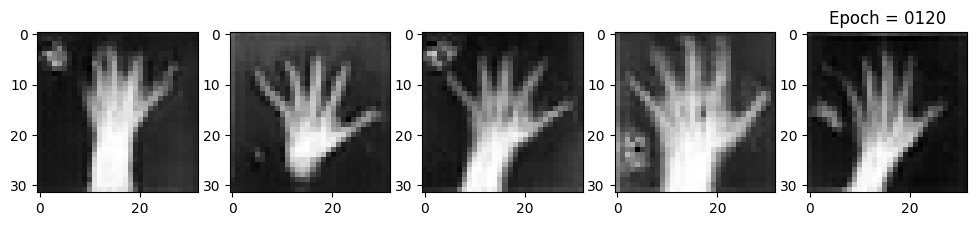

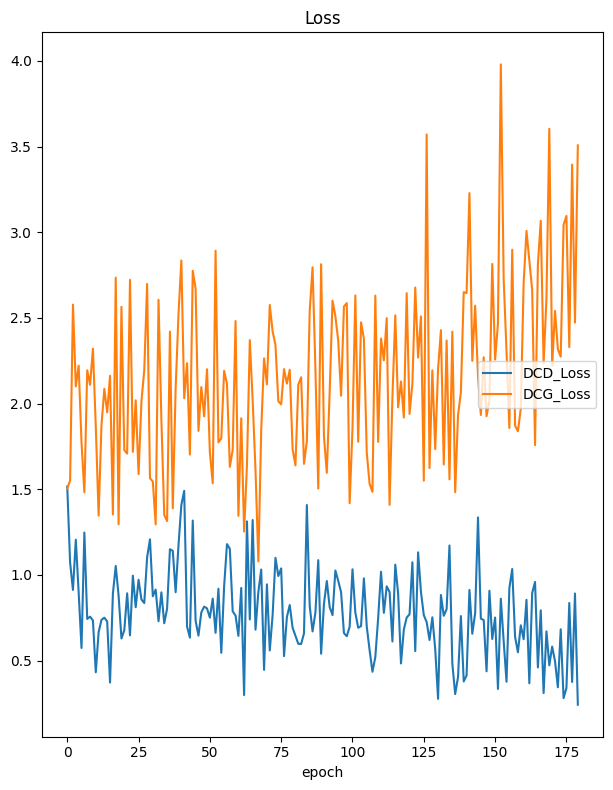

100%|██████████| 180/180 [06:04<00:00,  2.03s/it]

Loss
	DCD_Loss         	 (min:    0.242, max:    1.516, cur:    0.242)
	DCG_Loss         	 (min:    1.079, max:    3.980, cur:    3.507)


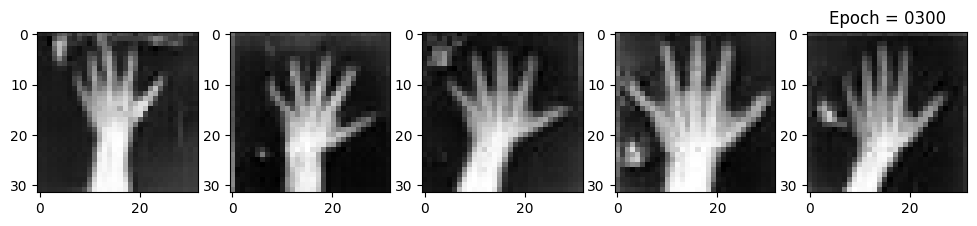

## Modification: add regularization term and use loss of WGANs
Regularization could help prevents overfitting, but the loss of WGANs looks does not help.

In [ ]:
def discriminator_regularizer(D1_logits, D1_arg, D2_logits, D2_arg):
    # Calculate gradients for real and fake data
    grad_D1_logits = D1_logits.requires_grad_()
    grad_D2_logits = D2_logits.requires_grad_()
    # Calculate the norms of the gradients
    grad_D1_logits_norm = torch.norm(grad_D1_logits.view(grad_D1_logits.size(0), -1), dim=1)
    grad_D2_logits_norm = torch.norm(grad_D2_logits.view(grad_D2_logits.size(0), -1), dim=1)

    # Compute regularizer terms
    reg_D1 = torch.mean(torch.square(grad_D1_logits_norm))
    reg_D2 = torch.mean(torch.square(grad_D2_logits_norm))

    # Combine the regularizers
    disc_regularizer = reg_D1 + reg_D2

    return disc_regularizer

def generator_regularizer(D1_logits, D1_arg):
    # Calculate gradients for real and fake data
    grad_D1_logits = D1_logits.requires_grad_()
    # Calculate the norms of the gradients
    grad_D1_logits_norm = torch.norm(grad_D1_logits.view(grad_D1_logits.size(0), -1), dim=1)

    # Compute regularizer terms
    reg_D1 = torch.mean(torch.square(grad_D1_logits_norm))

    return reg_D1

def gp_term(x_real, x_fake):
    m = bs
    epsilon = torch.rand(m, 1).to(device)
    x_interp = (epsilon * x_real + (1 - epsilon) * x_fake).to(device)
    x_interp = Variable(x_interp, requires_grad = True) # so we can compute the grad
    DCD_interp = DCD(x_interp)

    grad_DCD_interp = torch.autograd.grad(outputs = DCD_interp,
                 inputs = x_interp,
                 grad_outputs=torch.ones((bs, 1)).to(device),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]

    DCD_gp = (grad_DCD_interp.norm(2, dim=1) - 1) ** 2

    return DCD_gp


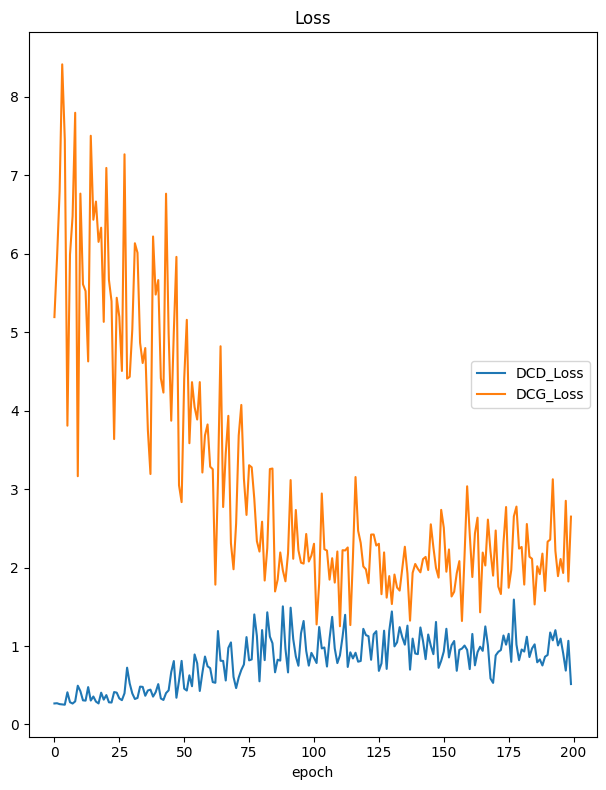

100%|██████████| 200/200 [07:06<00:00,  2.13s/it]

Loss
	DCD_Loss         	 (min:    0.252, max:    1.592, cur:    0.515)
	DCG_Loss         	 (min:    1.252, max:    8.416, cur:    2.650)


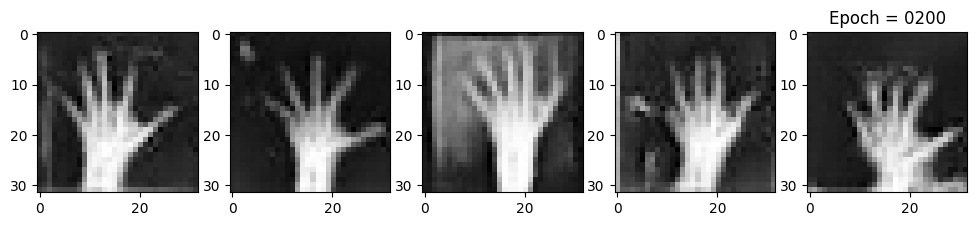

In [ ]:
"""add regularizations"""

#### use loss of WGANS

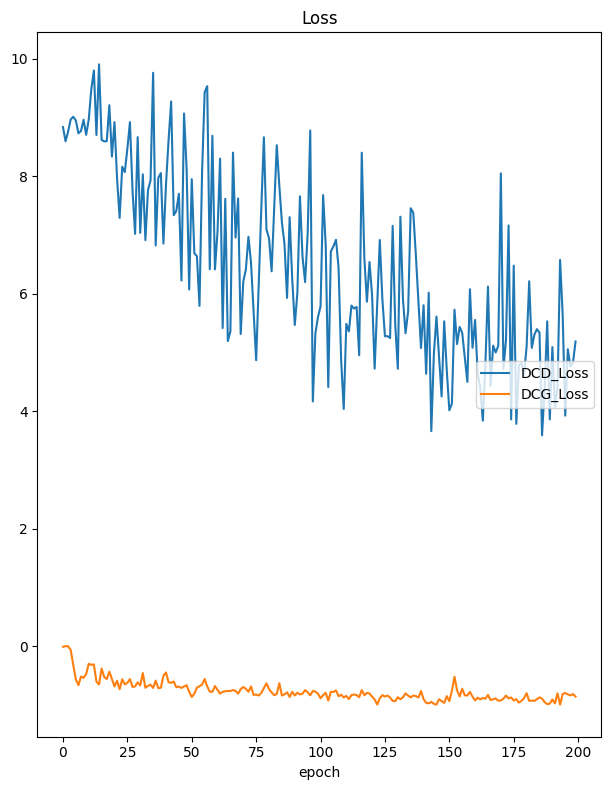

100%|██████████| 200/200 [09:42<00:00,  2.91s/it]

Loss
	DCD_Loss         	 (min:    3.588, max:    9.906, cur:    5.187)
	DCG_Loss         	 (min:   -0.999, max:   -0.003, cur:   -0.861)


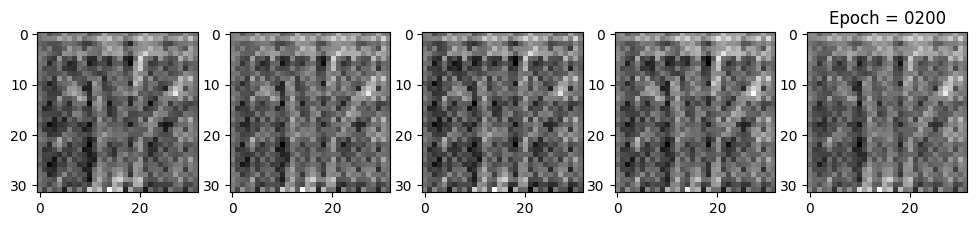

## Modification: add coefficient to regularization term and Wasserstein distance
Add coeficients helps to prevent the large influnces caused the two terms.

In [ ]:
def DCD_train(x, gamma=0.2, lambda_gp=3.0):
    """
    Function for discriminator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCD_loss.item() : float
        Loss value
    """
    # Function for discriminator training
    DCD.train()
    DCD_optimizer.zero_grad()

    # Reshape the input and prepare real labels
    x_real, y_real = x.view(bs, 1, 32, 32).to(device), torch.ones(bs, 1).to(device)  # Ensure x is [bs, 1, 32, 32]
    
    # Train discriminator on real data
    DCD_output_real = DCD(x_real)

    DCD_real_loss = criterion(DCD_output_real, y_real)

    # DCD_real_loss = F.binary_cross_entropy_with_logits(DCD_output_real, y_real)

    # Train discriminator on fake data
    z = torch.randn(bs, z_dim).to(device)  # Generate random noise
    x_fake, y_fake = DCG(z), torch.zeros(bs, 1).to(device)  # Generate fake data and prepare fake labels
    DCD_output_fake = DCD(x_fake)

    DCD_fake_loss = criterion(DCD_output_fake, y_fake)
    
    # DCD_fake_loss = F.binary_cross_entropy_with_logits(DCD_output_fake, y_fake)

    reg_loss = discriminator_regularizer(DCD_output_real, x_real, DCD_output_fake, x_fake)


    # Combine the losses and update
    # DCD_loss = DCD_real_loss + DCD_fake_loss
    DCD_gp = gp_term(x_real, x_fake)

    DCD_loss = torch.mean(DCD_real_loss + DCD_fake_loss) + (gamma/2.0)*reg_loss + (lambda_gp/2.0) * DCD_gp.mean()
    # DCD_loss = torch.mean(DCD_output_fake) - torch.mean(DCD_output_real) + lambda_gp * DCD_gp.mean()

    DCD_loss.backward()
    DCD_optimizer.step()

    return DCD_loss.item()


def DCG_train(x, gamma=0.2):
    """
    Function for generator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCG_loss.data.item() : float
        Loss value
    """
    #-------------- Function of the generator training -------------------#
    DCG.train()
    DCG_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    DCG_output = DCG(z)

    # obtain scores from D for the generated data
    DCD_output = DCD(DCG_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    DCG_loss = criterion(DCD_output, y)
    # DCG_loss = torch.mean(F.binary_cross_entropy_with_logits(DCD_output, y))
    # gen_loss = generator_regularizer(DCD_output, z)

    # DCG_loss = DCG_loss + (gamma/2.0)*gen_loss
    # DCG_loss = -torch.mean(DCD_output)
    # model update
    DCG_loss.backward()
    DCG_optimizer.step()

    return DCG_loss.data.item()

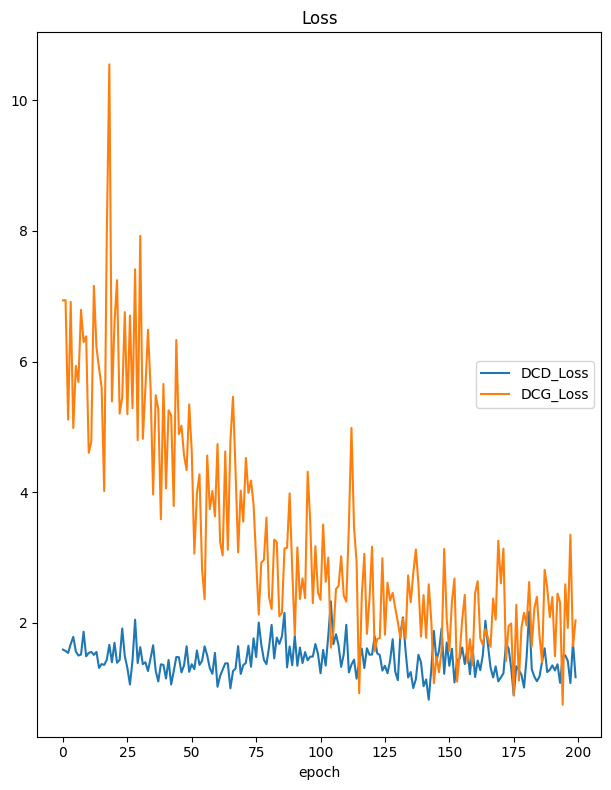

100%|██████████| 200/200 [09:46<00:00,  2.93s/it]

Loss
	DCD_Loss         	 (min:    0.824, max:    2.330, cur:    1.168)
	DCG_Loss         	 (min:    0.747, max:   10.551, cur:    2.037)


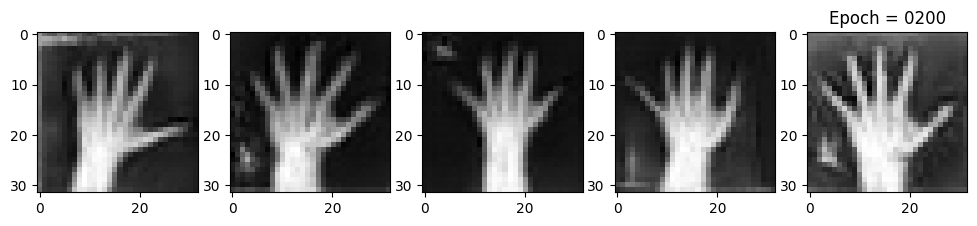

## Finetuning: use different coefficent of regularization terms and gradient penalty
It should use coefficent to limit the influnces of the two terms, but too small coefficent doea not help.

In [ ]:
def DCD_train(x, gamma=0.2, lambda_gp=3.0):
    """
    Function for discriminator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCD_loss.item() : float
        Loss value
    """
    # Function for discriminator training
    DCD.train()
    DCD_optimizer.zero_grad()

    # Reshape the input and prepare real labels
    x_real, y_real = x.view(bs, 1, 32, 32).to(device), torch.ones(bs, 1).to(device)  # Ensure x is [bs, 1, 32, 32]
    
    # Train discriminator on real data
    DCD_output_real = DCD(x_real)

    DCD_real_loss = criterion(DCD_output_real, y_real)

    # DCD_real_loss = F.binary_cross_entropy_with_logits(DCD_output_real, y_real)

    # Train discriminator on fake data
    z = torch.randn(bs, z_dim).to(device)  # Generate random noise
    x_fake, y_fake = DCG(z), torch.zeros(bs, 1).to(device)  # Generate fake data and prepare fake labels
    DCD_output_fake = DCD(x_fake)

    DCD_fake_loss = criterion(DCD_output_fake, y_fake)
    
    # DCD_fake_loss = F.binary_cross_entropy_with_logits(DCD_output_fake, y_fake)

    reg_loss = discriminator_regularizer(DCD_output_real, x_real, DCD_output_fake, x_fake)


    # Combine the losses and update
    # DCD_loss = DCD_real_loss + DCD_fake_loss
    DCD_gp = gp_term(x_real, x_fake)

    DCD_loss = torch.mean(DCD_real_loss + DCD_fake_loss) + (gamma/2.0)*reg_loss + (lambda_gp/2.0) * DCD_gp.mean()
    # DCD_loss = torch.mean(DCD_output_fake) - torch.mean(DCD_output_real) + lambda_gp * DCD_gp.mean()

    DCD_loss.backward()
    DCD_optimizer.step()

    return DCD_loss.item()


def DCG_train(x, gamma=0.2):
    """
    Function for generator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCG_loss.data.item() : float
        Loss value
    """
    #-------------- Function of the generator training -------------------#
    DCG.train()
    DCG_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    DCG_output = DCG(z)

    # obtain scores from D for the generated data
    DCD_output = DCD(DCG_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    DCG_loss = criterion(DCD_output, y)
    # DCG_loss = torch.mean(F.binary_cross_entropy_with_logits(DCD_output, y))
    # gen_loss = generator_regularizer(DCD_output, z)

    # DCG_loss = DCG_loss + (gamma/2.0)*gen_loss
    # DCG_loss = -torch.mean(DCD_output)
    # model update
    DCG_loss.backward()
    DCG_optimizer.step()

    return DCG_loss.data.item()

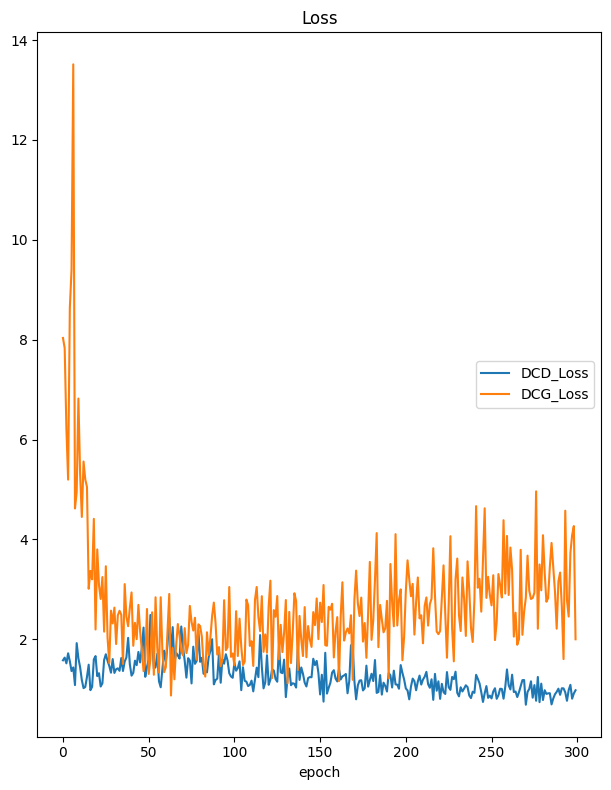

100%|██████████| 300/300 [48:12<00:00,  9.64s/it]

Loss
	DCD_Loss         	 (min:    0.689, max:    2.485, cur:    0.978)
	DCG_Loss         	 (min:    0.873, max:   13.514, cur:    1.999)


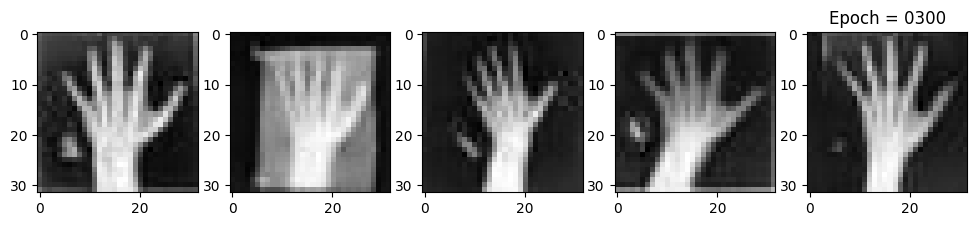

## Finetuning: use different loss function
Cannot add too many terms to loss function, this will cause the losses be too high and learn nothing.

In [ ]:
def DCD_train(x, gamma=0.5, lambda_gp=5.0):
    """
    Function for discriminator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCD_loss.item() : float
        Loss value
    """
    # Function for discriminator training
    DCD.train()
    DCD_optimizer.zero_grad()

    # Reshape the input and prepare real labels
    x_real, y_real = x.view(bs, 1, 32, 32).to(device), torch.ones(bs, 1).to(device)  # Ensure x is [bs, 1, 32, 32]
    
    # Train discriminator on real data
    DCD_output_real = DCD(x_real)

    DCD_real_loss = criterion(DCD_output_real, y_real)

    # DCD_real_loss = F.binary_cross_entropy_with_logits(DCD_output_real, y_real)

    # Train discriminator on fake data
    z = torch.randn(bs, z_dim).to(device)  # Generate random noise
    x_fake, y_fake = DCG(z), torch.zeros(bs, 1).to(device)  # Generate fake data and prepare fake labels
    DCD_output_fake = DCD(x_fake)

    DCD_fake_loss = criterion(DCD_output_fake, y_fake)
    
    # DCD_fake_loss = F.binary_cross_entropy_with_logits(DCD_output_fake, y_fake)

    reg_loss = discriminator_regularizer(DCD_output_real, x_real, DCD_output_fake, x_fake)


    # Combine the losses and update
    # DCD_loss = DCD_real_loss + DCD_fake_loss
    DCD_gp = gp_term(x_real, x_fake)

    DCD_loss = torch.mean(DCD_real_loss + DCD_fake_loss) + (gamma/2.0)*reg_loss + (lambda_gp/2.0) * DCD_gp.mean()
    # DCD_loss = torch.mean(DCD_output_fake) - torch.mean(DCD_output_real) + lambda_gp * DCD_gp.mean()

    DCD_loss.backward()
    DCD_optimizer.step()

    return DCD_loss.item()


def DCG_train(x, gamma=0.2):
    """
    Function for generator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCG_loss.data.item() : float
        Loss value
    """
    #-------------- Function of the generator training -------------------#
    DCG.train()
    DCG_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    DCG_output = DCG(z)

    # obtain scores from D for the generated data
    DCD_output = DCD(DCG_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    DCG_loss = criterion(DCD_output, y)
    # DCG_loss = torch.mean(F.binary_cross_entropy_with_logits(DCD_output, y))
    # gen_loss = generator_regularizer(DCD_output, z)

    # DCG_loss = DCG_loss + (gamma/2.0)*gen_loss
    # DCG_loss = -torch.mean(DCD_output)
    # model update
    DCG_loss.backward()
    DCG_optimizer.step()

    return DCG_loss.data.item()

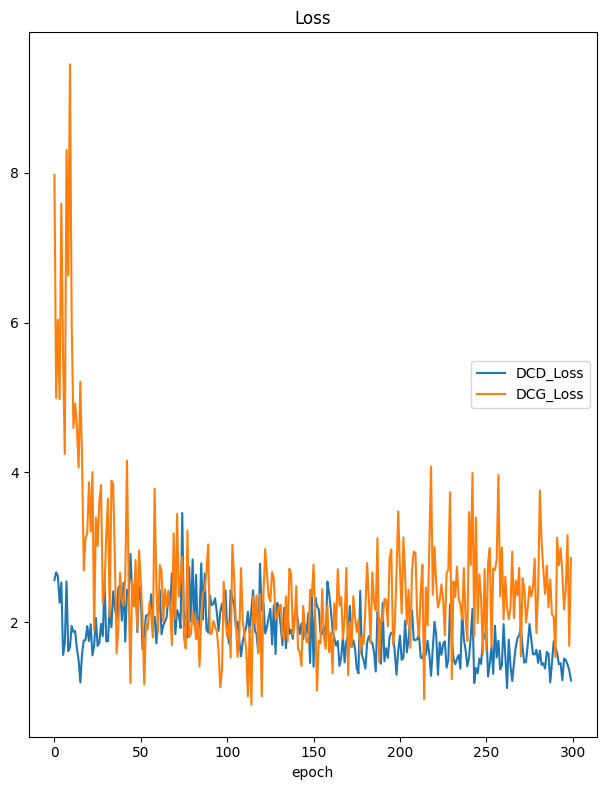

100%|██████████| 300/300 [44:20<00:00,  8.87s/it]

Loss
	DCD_Loss         	 (min:    1.121, max:    3.458, cur:    1.222)
	DCG_Loss         	 (min:    0.899, max:    9.446, cur:    2.854)


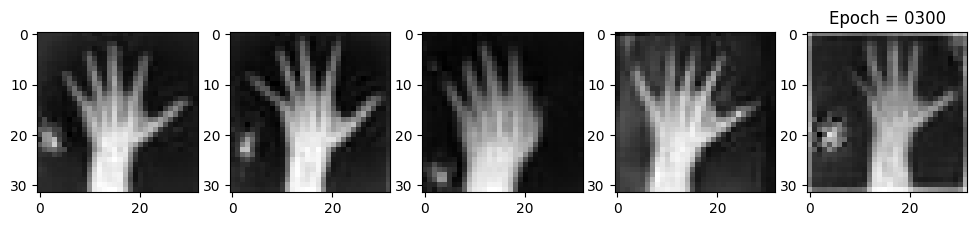

### The loss funtion with regularizers.

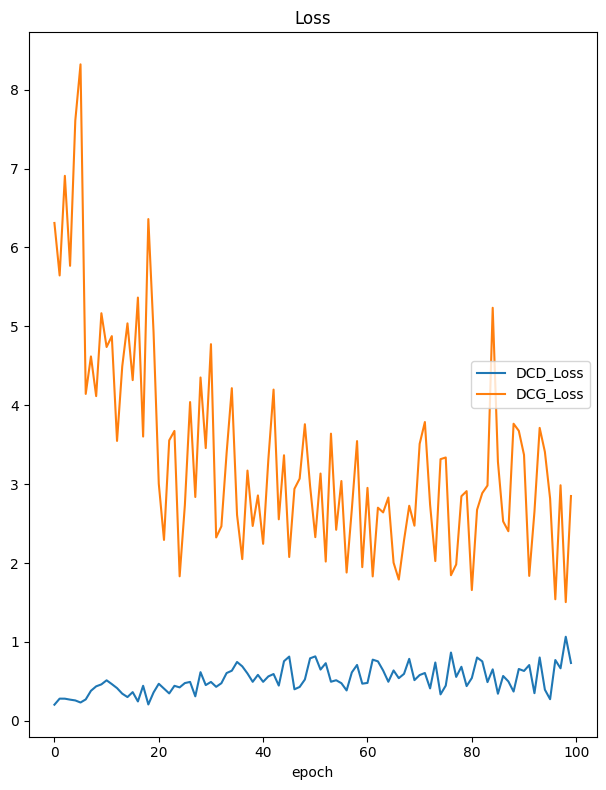

100%|██████████| 100/100 [16:20<00:00,  9.80s/it]

Loss
	DCD_Loss         	 (min:    0.204, max:    1.066, cur:    0.733)
	DCG_Loss         	 (min:    1.504, max:    8.320, cur:    2.849)


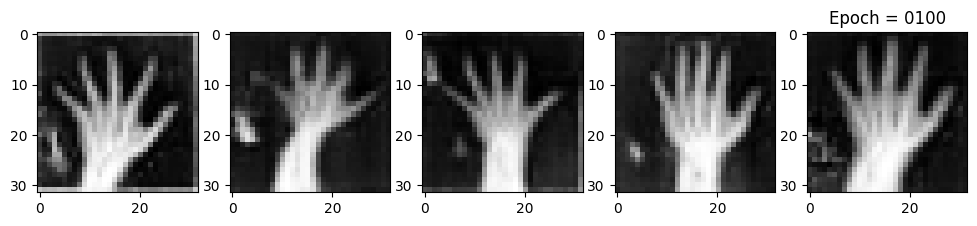

In [ ]:
DCG_loss = criterion(DCD_output, y)
gen_loss = generator_regularizer(DCD_output, z)
DCG_loss = torch.mean(DCG_loss + gamma * gen_loss)
DCD_loss = torch.mean(DCD_real_loss + DCD_fake_loss) + gamma * torch.mean(reg_loss + DCD_gp.mean())


### combine regularizers

In [ ]:
def DCD_train(x, gamma=0.3):
    """
    Function for discriminator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCD_loss.item() : float
        Loss value
    """
    # Function for discriminator training
    DCD.train()
    DCD_optimizer.zero_grad()

    # Reshape the input and prepare real labels
    x_real, y_real = x.view(bs, 1, 32, 32).to(device), torch.ones(bs, 1).to(device)  # Ensure x is [bs, 1, 32, 32]
    
    # Train discriminator on real data
    DCD_output_real = DCD(x_real)

    DCD_real_loss = criterion(DCD_output_real, y_real)

    # DCD_real_loss = F.binary_cross_entropy_with_logits(DCD_output_real, y_real) # alternative loss function

    # Train discriminator on fake data
    z = torch.randn(bs, z_dim).to(device)  # Generate random noise
    x_fake, y_fake = DCG(z), torch.zeros(bs, 1).to(device)  # Generate fake data and prepare fake labels
    DCD_output_fake = DCD(x_fake)

    DCD_fake_loss = criterion(DCD_output_fake, y_fake)
    
    # DCD_fake_loss = F.binary_cross_entropy_with_logits(DCD_output_fake, y_fake) # alternative loss function

    reg_loss = discriminator_regularizer(DCD_output_real, x_real, DCD_output_fake, x_fake) # Compute the regularizer


    # Combine the losses and update the model
    DCD_gp = gp_term(x_real, x_fake) # Compute the gradient penalty term
    DCD_loss = torch.mean(DCD_real_loss + DCD_fake_loss) + gamma * (reg_loss + DCD_gp.mean())
    
    # DCD_loss = torch.mean(DCD_output_fake) - torch.mean(DCD_output_real) + lambda_gp * DCD_gp.mean()
    # DCD_loss = DCD_real_loss + DCD_fake_loss

    DCD_loss.backward()
    DCD_optimizer.step()

    return DCD_loss.item()


def DCG_train(x, gamma=0.1):
    """
    Function for generator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCG_loss.data.item() : float
        Loss value
    """
    #-------------- Function of the generator training -------------------#
    DCG.train()
    DCG_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    DCG_output = DCG(z)

    # obtain scores from D for the generated data
    DCD_output = DCD(DCG_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    DCG_loss = criterion(DCD_output, y)
    # DCG_loss = torch.mean(F.binary_cross_entropy_with_logits(DCD_output, y))
    # gen_loss = generator_regularizer(DCD_output, z)
    # DCG_loss = torch.mean(DCG_loss + gamma * gen_loss)
    # DCG_loss = -torch.mean(DCD_output)

    # model update
    DCG_loss.backward()
    DCG_optimizer.step()

    return DCG_loss.data.item()

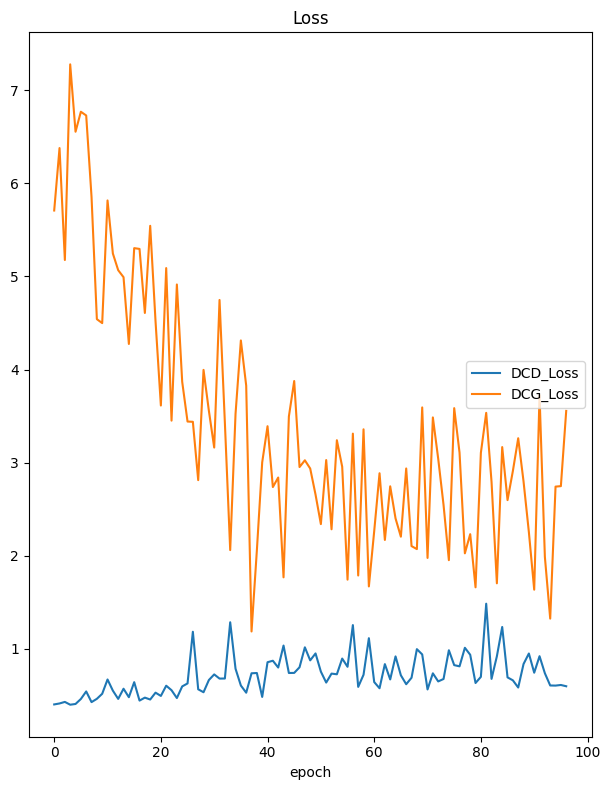

In [ ]:
model_train(n_epochs=100, plot_output=True, )

## Finetuning: add normalizations
Firstly, use normalize with mean=0, std=1, the improvement of performance looks little but the computational time increase obviously.

In [ ]:
transform = transforms.Compose([transforms.Normalize(mean=(0), std=(1))])
# Create dataset and dataloader
batch_size = 32
hand_train_dataset = HandDataset(root="./real_hands/",transform=transform)
train_loader = DataLoader(hand_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

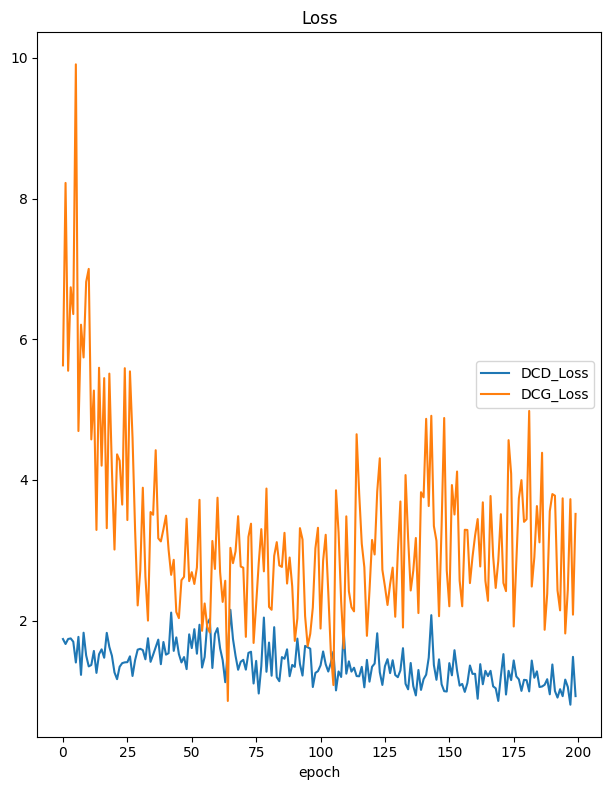

100%|██████████| 200/200 [31:44<00:00,  9.52s/it]

Loss
	DCD_Loss         	 (min:    0.804, max:    2.153, cur:    0.926)
	DCG_Loss         	 (min:    0.857, max:    9.909, cur:    3.517)


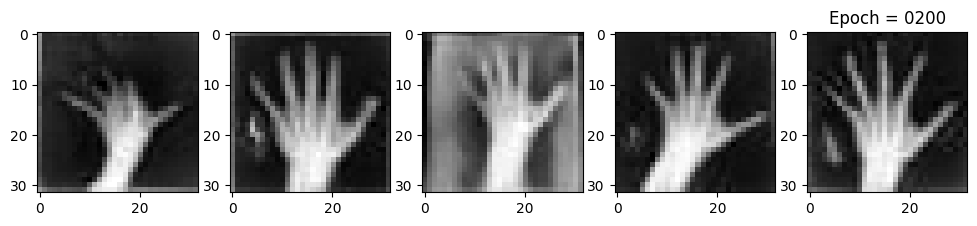

### Now I use normalize(mean=0.5, std=0.5) from lecture notes
It is clear that the losses converges higher than use mean=0, std=1

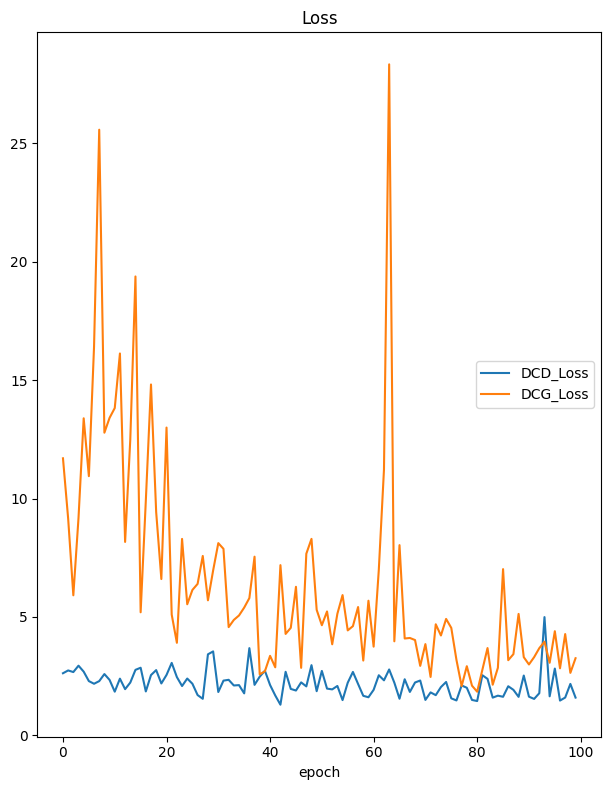

100%|██████████| 100/100 [16:16<00:00,  9.77s/it]

Loss
	DCD_Loss         	 (min:    1.295, max:    4.995, cur:    1.595)
	DCG_Loss         	 (min:    1.843, max:   28.339, cur:    3.258)


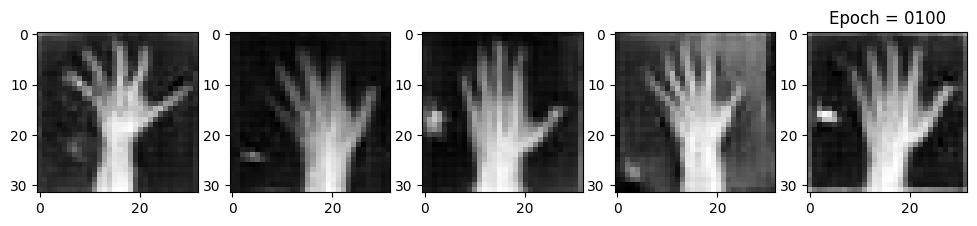

## Finetuning: change the learning batch size to 16
After several trying, seems that 32 is the best batch size

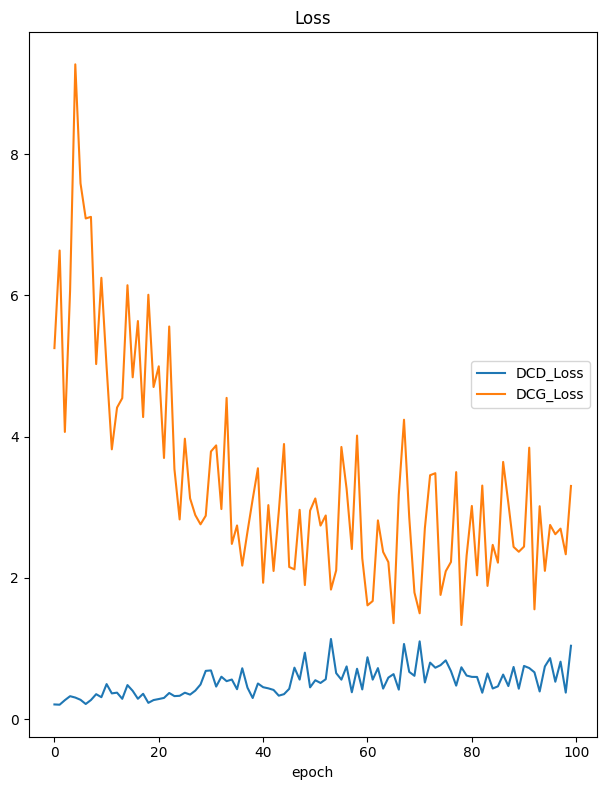

100%|██████████| 100/100 [16:04<00:00,  9.65s/it]

Loss
	DCD_Loss         	 (min:    0.206, max:    1.136, cur:    1.040)
	DCG_Loss         	 (min:    1.334, max:    9.271, cur:    3.302)


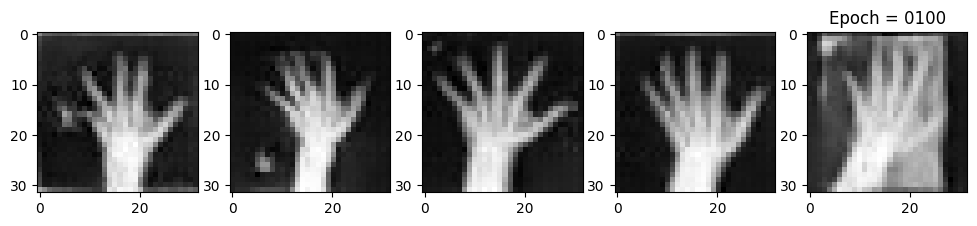

In [ ]:
model_train(n_epochs=100, plot_output=True, )